In [1]:
import json
import nltk
import re
import itertools
from time import sleep
import sys
import numpy
import scipy
import time
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from collections import Counter
with open("proj1_data.json") as fp:
    data = json.load(fp)

In [2]:
train = data[:10000]
validation = data[10000:11000]
test = data[11000:12000]

## Part 1: feature extraction

In [3]:
def countAllFrequencyNaive(dataSet): 
    totalString = str()
    for d in dataSet: 
        totalString = totalString + ' ' + d['text']
    countNaive = Counter([s for s in totalString.lower().strip().split()])
    totalCount = []
    return list(map(lambda v: v[0], countNaive.most_common(160)))

In [4]:
def countAllFrequencyStopWord(dataSet): 
    
    totalString = str()
    
    for d in dataSet: 
        totalString = totalString + ' ' + d['text']
        
    tokenizer = RegexpTokenizer(r'\w+')
    withoutPunc = tokenizer.tokenize(totalString)
    
    stopwordsSet = set(stopwords.words())
    
    countDict = Counter(s.lower() for s in withoutPunc if s.lower() not in stopwordsSet)
    
    return list(map(lambda v: v[0], countDict.most_common(160)))

In [5]:
# word count, no removal of punctuations
# @Param: singleText: text to process, numberOfFeatures: 0, 60, 160?
# @Return: vector of count (x in description)
def wordCountNaive(singleText, numberOfFeatures, totalCount): 
    
    countNaive = Counter([s.lower() for s in singleText.split()])
    returnVector = []
    for word in totalCount[:numberOfFeatures]: 
        returnVector.append(float(countNaive[word]))
    return returnVector


# word count, remove punc and stopwords to imporve model
# @Param: singleText: text to process, numberOfFeatures: 0, 60, 160?
# @Return: vector of count (x in description)
def wordCountWithStopwords(singleText, numberOfFeatures, totalCount): 
    
    tokenizer = RegexpTokenizer(r'\w+')
    withoutPunc = tokenizer.tokenize(singleText)
    
    stopwordsSet = set(stopwords.words())
    
    countDict = Counter([s.lower() for s in withoutPunc if s.lower() not in stopwordsSet])
    
    returnVector = []
    for word in totalCount[:numberOfFeatures]: 
        returnVector.append(float(countDict[word]))
    
    return returnVector

In [6]:
def pythonListTranspose(xl): 
    return list(map(list, itertools.zip_longest(*xl)))

In [7]:
# Feature Parser
# @Param: dataVector: sliced original dataset, wordCountFunction: <str> -> ndarray<float>, 
# wordPOSFunction: str -> list<float>, numberOfTextFeature: 0 to shut down Text Processing (Text Features)
# featureType: 
# @Return: tuple<ndarray, list>: xEngineered, yExtracted: rows: vector<samplePoint>, samplePoint[0->2]: basic Features, 
# samplePoint[3->162]: text, samplePoint[163->167]: extra
def parseFeatures(dataVector, wordCountFunction, numberOfTextFeatures, featureType): 
    y = []
    childrenFeature = []
    controversialityFeature = []
    isRootFeature = []
    processedTextFeature = []
    verbFeature = []
    nounFeature = []
    adjFeature = []
    urlFeature = []
    childAndControv = []
    childAndisRoot = []
    allInteracted = []
    controvAndisRoot = []
    identityFeature = []
    countFeature = []
    c = 0
    lenV = len(dataVector)
    for dataPoint in dataVector: 
        
        # Basic Features
        y.append(float(dataPoint['popularity_score']))
        if 'children' in featureType: 
            childrenFeature.append(float(dataPoint['children']))
        if 'controv' in featureType: 
            controversialityFeature.append(float(dataPoint['controversiality']))
        identityFeature.append(1.0)
        isRootVar = -1.0
        if 'isRoot' in featureType: 
            if dataPoint['is_root'] == True: 
                isRootVar = 1.0
                isRootFeature.append(isRootVar)
            else: 
                isRootVar = 0.0
                isRootFeature.append(isRootVar)
        
        # Text Features: 0 to shut down text feature
        if numberOfTextFeatures > 0 and 'text' in featureType: 
            processedTextFeature.append(wordCountFunction(dataPoint['text'], numberOfTextFeatures))
        
        # Extra Features
        if 'noun' in featureType or 'verb' in featureType or 'adj' in featureType: 
            wordAnalysis = wordPOSCountWithStopwords(dataPoint['text'])
        if 'verb' in featureType: 
            verbFeature.append(wordAnalysis[0])
        if 'noun' in featureType: 
            nounFeature.append(wordAnalysis[1])
        if 'adj' in featureType: 
            adjFeature.append(wordAnalysis[2])
        if 'url' in featureType: 
            urlFeature.append(hasURL(dataPoint['text']))
        if 'count' in featureType: 
            countFeature.append(float(len(dataPoint['text'].split())))
            
        # Interaction Effect: 
        if 'child and controv' in featureType: 
            childAndControv.append(float(dataPoint['children']) * float(dataPoint['controversiality']))
        if 'child and isRoot' in featureType: 
            childAndisRoot.append(float(dataPoint['children']) * isRootVar)
        if 'all interacted' in featureType: 
            allInteracted.append(float(dataPoint['children']) * isRootVar  * float(dataPoint['controversiality']))
        if 'controv and isRoot' in featureType: 
            controvAndisRoot.append(isRootVar  * float(dataPoint['controversiality']))
        
        # Process Bar
        sys.stdout.write('\r')
        count = int((float(c) / float(lenV)) * 100)
        sys.stdout.write("[%-20s] %d%%" % ('='*int(count / 5), count))
        sleep(0.001)
        sys.stdout.flush()
        c = c + 1
    if len(processedTextFeature) > 0: 
        processedTextFeature = pythonListTranspose(processedTextFeature)
    returnTotal = [childrenFeature, controversialityFeature, isRootFeature, verbFeature, nounFeature, adjFeature, urlFeature, countFeature, childAndControv, childAndisRoot, allInteracted, controvAndisRoot, identityFeature] + processedTextFeature
    return pythonListTranspose([x for x in returnTotal if len(x) > 0]), pythonListTranspose([y])

In [8]:
def parseTransformedFeatures(dataVector, wordCountFunction, numberOfTextFeatures, featureType): 
    y = []
    childrenFeature = []
    childrenFeatureO = []
    controversialityFeature = []
    isRootFeature = []
    processedTextFeatureO = []
    processedTextFeature = []
    verbFeature = []
    nounFeature = []
    adjFeature = []
    urlFeature = []
    childAndControv = []
    childAndisRoot = []
    allInteracted = []
    controvAndisRoot = []
    identityFeature = []
    countFeature = []
    c = 0
    lenV = len(dataVector)
    for dataPoint in dataVector: 
        
        # Basic Features
        y.append(float(dataPoint['popularity_score']))
        if 'children' in featureType: 
            childrenFeatureO.append(float(dataPoint['children']))
        if 'childrenT' in featureType: 
            childrenFeature.append(1.0 - numpy.exp(-0.04 * float(dataPoint['children'])))
        if 'controv' in featureType: 
            controversialityFeature.append(float(dataPoint['controversiality']))
        identityFeature.append(1.0)
        isRootVar = -1.0
        if 'isRoot' in featureType: 
            if dataPoint['is_root'] == True: 
                isRootVar = 1.0
                isRootFeature.append(isRootVar)
            else: 
                isRootVar = 0.0
                isRootFeature.append(isRootVar)
        
        # Text Features: 0 to shut down text feature
        if numberOfTextFeatures > 0 and 'text' in featureType: 
            arr = wordCountFunction(dataPoint['text'], numberOfTextFeatures)
            processedTextFeatureO.append([a for a in arr])
        if numberOfTextFeatures > 0 and 'textT' in featureType: 
            arr = wordCountFunction(dataPoint['text'], numberOfTextFeatures)
            processedTextFeature.append([numpy.exp(-0.04 * (a)) * 1 for a in arr]) # numpy.cos(3 * a)
            
        # Extra Features
        if 'noun' in featureType or 'verb' in featureType or 'adj' in featureType: 
            wordAnalysis = wordPOSCountWithStopwords(dataPoint['text'])
        if 'verb' in featureType: 
            verbFeature.append(wordAnalysis[0])
        if 'noun' in featureType: 
            nounFeature.append(wordAnalysis[1])
        if 'adj' in featureType: 
            adjFeature.append(wordAnalysis[2])
        if 'url' in featureType: 
            urlFeature.append(hasURL(dataPoint['text']))
        if 'count' in featureType: 
            countFeature.append(float(len(dataPoint['text'].split())))
            
        # Interaction Effect: 
        if 'child and controv' in featureType: 
            childAndControv.append(float(dataPoint['children']) * float(dataPoint['controversiality']))
        if 'child and isRoot' in featureType: 
            childAndisRoot.append(float(dataPoint['children']) * isRootVar)
        if 'all interacted' in featureType: 
            allInteracted.append(float(dataPoint['children']) * isRootVar * float(dataPoint['controversiality']))
        if 'controv and isRoot' in featureType: 
            controvAndisRoot.append(isRootVar  * float(dataPoint['controversiality']))
        
        # Process Bar
        sys.stdout.write('\r')
        count = int((float(c) / float(lenV)) * 100)
        sys.stdout.write("[%-20s] %d%%" % ('='*int(count / 5), count))
        sleep(0.001)
        sys.stdout.flush()
        c = c + 1
    
    if len(processedTextFeature) > 0: 
        processedTextFeature = pythonListTranspose(processedTextFeature)
        processedTextFeatureO = pythonListTranspose(processedTextFeatureO)
        
    returnTotal = [childrenFeatureO, childrenFeature, controversialityFeature, isRootFeature, verbFeature, nounFeature, adjFeature, urlFeature, childAndControv, childAndisRoot, allInteracted, controvAndisRoot, countFeature, identityFeature] + processedTextFeature + processedTextFeatureO
    return pythonListTranspose([x for x in returnTotal if len(x) > 0]), pythonListTranspose([y])

## Part 2: Regression Algorithms

In [9]:
def meanSquareError(valX, valY, w): 
    diffenence = numpy.power(numpy.transpose(numpy.subtract(valY, numpy.matmul(valX, w)))[0], 2)
    return numpy.divide(numpy.sum(diffenence), len(valY))

In [10]:
def closedFormLinearRegression(x, y): 
    xT = numpy.transpose(numpy.array(x))
    return numpy.matmul(numpy.matmul(scipy.linalg.inv(numpy.matmul(xT, numpy.array(x))), xT), numpy.array(y))

In [11]:
def gradientDescentLinearRegression(learnRateFunction, x, y, tol): 
    i = 1
    weight = numpy.array([[0.0] for l in range(len(x[0]))])
    weightN = numpy.array([[0.0] for l in range(len(x[0]))])
    xT = numpy.transpose(x)
    xTx = numpy.matmul(xT, x)
    xTy = numpy.matmul(xT, y)
    while True: 
        weight = weightN
        weightN = numpy.subtract(weight, 2 * learnRateFunction(i) * numpy.subtract(numpy.matmul(xTx, weight), xTy))
        i = i + 1
        if numpy.linalg.norm(numpy.subtract(weightN, weight), 2) <= tol: 
            break
    return weightN

## Part 3: Closed Form and Gradient Descent

In [12]:
trainFeatures = parseFeatures(train, lambda u, v: wordCountNaive(u, v, tFreq), 0, ['children', 'controv', 'isRoot'])
validationFeatures = parseFeatures(validation, lambda u, v: wordCountNaive(u, v, vFreq), 0, ['children', 'controv', 'isRoot'])

[=================== ] 99%

In [13]:
startClosed = time.time()
resultClosed = closedFormLinearRegression(trainFeatures[0], trainFeatures[1])
endClosed = time.time()
errorClosed = meanSquareError(validationFeatures[0], validationFeatures[1], resultClosed)
errorTrained = meanSquareError(trainFeatures[0], trainFeatures[1], resultClosed)
print('result of closed form: \n', resultClosed)
print('error of closed form validation: \n', errorClosed)
print('error of closed form training: \n', errorTrained)
print('runtime of closed from: \n', endClosed - startClosed)

result of closed form: 
 [[ 0.37536403]
 [-1.08584747]
 [-0.22627679]
 [ 0.82092517]]
error of closed form validation: 
 1.0203266848431447
error of closed form training: 
 1.0846830709157251
runtime of closed from: 
 0.19705605506896973


In [14]:
startGD = time.time()
resultGradient = gradientDescentLinearRegression(lambda v: float(0.0023 / (float(v) + 6.0)), trainFeatures[0], trainFeatures[1], 0.00000005)
endGD = time.time()
errorGradient = meanSquareError(validationFeatures[0], validationFeatures[1], resultGradient)
errorGradientT = meanSquareError(trainFeatures[0], trainFeatures[1], resultGradient)
print('result of gradient descent: \n', resultGradient)
print('error of gradient descent validation: \n', errorGradient)
print('error of gradient descent training: \n', errorGradientT)
print('runtime of gradient descent: \n', endGD - startGD)

result of gradient descent: 
 [[ 0.37554273]
 [-1.15426782]
 [-0.22674518]
 [ 0.82186164]]
error of gradient descent validation: 
 1.0200797758166562
error of gradient descent training: 
 1.0847370931579012
runtime of gradient descent: 
 24.59604501724243


conclusion: closed form gives less error and less time

## Part 3: 60 and 160 text features

In [15]:
tFreq = countAllFrequencyNaive(train)
trainFeatures60 = parseFeatures(train, lambda u, v: wordCountNaive(u, v, tFreq), 60, ['children', 'controv', 'isRoot', 'text'])
trainFeatures160 = parseFeatures(train, lambda u, v: wordCountNaive(u, v, tFreq), 160, ['children', 'controv', 'isRoot', 'text'])

[=================== ] 99%

In [16]:
vFreq = countAllFrequencyNaive(validation)
validationFeatures60 = parseFeatures(validation, lambda u, v: wordCountNaive(u, v, tFreq), 60, ['children', 'controv', 'isRoot', 'text'])
validationFeatures160 = parseFeatures(validation, lambda u, v: wordCountNaive(u, v, tFreq), 160, ['children', 'controv', 'isRoot', 'text'])

[=================== ] 99%

In [17]:
resultClosed60 = closedFormLinearRegression(trainFeatures60[0], trainFeatures60[1])
errorClosed60 = meanSquareError(validationFeatures60[0], validationFeatures60[1], resultClosed60)
errorTrained60 = meanSquareError(trainFeatures60[0], trainFeatures60[1], resultClosed60)
# print('result of closed form: \n', resultClosed60)
print('error of closed form validation: \n', errorClosed60)
print('error of closed form trained: \n', errorTrained60)

error of closed form validation: 
 0.9839397297217665
error of closed form trained: 
 1.060429141685383


In [18]:
resultClosed160 = closedFormLinearRegression(trainFeatures160[0], trainFeatures160[1])
errorClosed160 = meanSquareError(validationFeatures160[0], validationFeatures160[1], resultClosed160)
errorTrained160 = meanSquareError(trainFeatures160[0], trainFeatures160[1], resultClosed160)
# print('result of closed form: \n', resultClosed160)
print('error of closed form validation: \n', errorClosed160)
print('error of closed form trained: \n', errorTrained160)

error of closed form validation: 
 0.9950693970669264
error of closed form trained: 
 1.0477763217987115


conclusion: 60 features are better than 160, validation error larger than closed form in 160: potentially overfitting

## Part 3: [Improvement 1] Transform of 'Children' feature

In [19]:
trainFeaturesI = parseTransformedFeatures(train, lambda u, v: wordCountNaive(u, v, tFreq), 0, ['childrenT', 'controv', 'isRoot'])
validationFeaturesI = parseTransformedFeatures(validation, lambda u, v: wordCountNaive(u, v, tFreq), 0, ['childrenT', 'controv', 'isRoot']) 

[=================== ] 99%

In [20]:
resultClosedI = closedFormLinearRegression(trainFeaturesI[0], trainFeaturesI[1])
errorClosedI = meanSquareError(validationFeaturesI[0], validationFeaturesI[1], resultClosedI)
errorTrainedI = meanSquareError(trainFeaturesI[0], trainFeaturesI[1], resultClosedI)
# print('result of closed form: \n', resultClosedI)
print('error of closed form validation: \n', errorClosedI)
print('error of closed form trained: \n', errorTrainedI)

error of closed form validation: 
 1.0029820618160374
error of closed form trained: 
 1.0456152576445137


Conclusion: use of g(x) = 1-exp(-0.04x) to transform children variable decreases loss from 1.020326684843145 down to 0.017344623027107486 on validation set (0.017638854694864925 improvement)

## Part 3: [Improvement 2] Transform of 'Children' feature

In [21]:
tFreq = countAllFrequencyNaive(data)
trainFeaturesI60 = parseTransformedFeatures(train, lambda u, v: wordCountNaive(u, v, tFreq), 60, ['children', 'controv', 'isRoot', 'textT'])
validationFeaturesI60 = parseTransformedFeatures(validation, lambda u, v: wordCountNaive(u, v, tFreq), 60, ['children', 'controv', 'isRoot', 'textT']) 

[=================== ] 99%

In [22]:
resultClosedI60 = closedFormLinearRegression(trainFeaturesI60[0], trainFeaturesI60[1])
errorClosedI60 = meanSquareError(validationFeaturesI60[0], validationFeaturesI60[1], resultClosedI60)
errorTrainedI60 = meanSquareError(trainFeaturesI60[0], trainFeaturesI60[1], resultClosedI60)
# print('result of closed form: \n', resultClosedI60)
print('error of closed form validation: \n', errorClosedI60)
print('error of closed form trained: \n', errorTrainedI60)

error of closed form validation: 
 0.970215126374883
error of closed form trained: 
 1.058597084267706


Conclusion: use of g(x) = exp(-0.04 * (x)) to transform all text features decreases loss from 0.9839397297217665 down to 0.970215126374883 on validation set (0.013724603346883413 improvement)

## Extra experiment: count word frequencies and eliminate stopwords

In [23]:
tFreqS = countAllFrequencyStopWord(train)
trainFeatures60S = parseFeatures(data[:10000], lambda u, v: wordCountWithStopwords(u, v, tFreqS), 60, ['children', 'controv', 'isRoot', 'text'])
trainFeatures160S = parseFeatures(data[:10000], lambda u, v: wordCountWithStopwords(u, v, tFreqS), 160, ['children', 'controv', 'isRoot', 'text'])

[=================== ] 99%

In [24]:
validationFeatures60S = parseFeatures(validation, lambda u, v: wordCountWithStopwords(u, v, tFreqS), 60, ['children', 'controv', 'isRoot', 'text'])
validationFeatures160S = parseFeatures(validation, lambda u, v: wordCountWithStopwords(u, v, tFreqS), 160, ['children', 'controv', 'isRoot', 'text'])

[=================== ] 99%

In [25]:
resultClosed60S = closedFormLinearRegression(trainFeatures60S[0], trainFeatures60S[1])
errorClosed60S = meanSquareError(validationFeatures60S[0], validationFeatures60S[1], resultClosed60S)
errorTrained60S = meanSquareError(trainFeatures60S[0], trainFeatures60S[1], resultClosed60S)
# print('result of closed form: \n', resultClosed60S)
print('error of closed form validation: \n', errorClosed60S)
print('error of closed form trained: \n', errorTrained60S)

error of closed form validation: 
 1.0160834359569333
error of closed form trained: 
 1.0690435344142226


In [26]:
resultClosed160S = closedFormLinearRegression(trainFeatures160S[0], trainFeatures160S[1])
errorClosed160S = meanSquareError(validationFeatures160S[0], validationFeatures160S[1], resultClosed160S)
errorTrained160S = meanSquareError(trainFeatures160S[0], trainFeatures160S[1], resultClosed160S)
# print('result of closed form: \n', resultClosed160S)
print('error of closed form validation: \n', errorClosed160S)
print('error of closed form trained: \n', errorTrained160S)

error of closed form validation: 
 1.0377809673400562
error of closed form trained: 
 1.0504238189332942


conclusion: eliminating stopwords does not gives better result

## Experimenting with potential new features: fraction of noun and existence of URL

In [27]:
# word pos count, remove punc and stopwords to imporve model
# @Param: singleText: text to process
# @Return: vector of [verbcount, nouncount, adjcount]
def wordPOSCountWithStopwords(singleText): 
    
    tokenizer = RegexpTokenizer(r'\w+')
    withoutPunc = tokenizer.tokenize(singleText)
    setOfStop = set(stopwords.words())
    tagged = nltk.pos_tag([s.lower() for s in withoutPunc if s.lower() not in setOfStop])
    
    verbTotal, nounTotal, adjTotal = 0, 0, 0
    counts = Counter(tag for wordType, tag in tagged)
    totalCount = len(singleText.split())
    
    for key, value in counts.items(): 
        if 'NN' in key: 
            nounTotal = nounTotal + 1
        elif 'VB' in key: 
            verbTotal = verbTotal + 1
        elif 'JJ' in key: 
            adjTotal = adjTotal + 1
            
    if totalCount > 0: 
        return [float(verbTotal) / totalCount, float(nounTotal) / totalCount, float(adjTotal) / totalCount]
    else: 
        return [0.0, 0.0, 0.0]
# Test: 
# print(wordPOSCountWithStopwords(data[3]['text']))
# print(data[3]['text'])


def hasURL(text): 
    if re.match(r"(http://[^ ]+)", text) != None: 
        return 1.0
    else: 
        return 0.0

### With fraction of noun in whole words

In [28]:
trainMyFeatures60 = parseFeatures(train, lambda u, v: wordCountNaive(u, v, tFreq), 0, ['children', 'controv', 'isRoot', 'noun'])

[=================== ] 99%

In [29]:
validationMyFeatures60 = parseFeatures(validation, lambda u, v: wordCountNaive(u, v, tFreq), 0, ['children', 'controv', 'isRoot', 'noun'])

[=================== ] 99%

In [30]:
resultMyClosed = closedFormLinearRegression(trainMyFeatures60[0], trainMyFeatures60[1])
errorMyClosed = meanSquareError(validationMyFeatures60[0], validationMyFeatures60[1], resultMyClosed)
errorMyTrained = meanSquareError(trainMyFeatures60[0], trainMyFeatures60[1], resultMyClosed)
# print('result of closed form: \n', resultMyClosed)
print('error of closed form validation: \n', errorMyClosed)
print('error of closed form trained: \n', errorMyTrained)

error of closed form validation: 
 1.0205294940039473
error of closed form trained: 
 1.0846431658913824


### With URL

In [31]:
trainMyFeaturesURL60 = parseFeatures(train, lambda u, v: wordCountNaive(u, v, tFreq), 0, ['children', 'controv', 'isRoot', 'url'])
validationMyFeaturesURL60 = parseFeatures(validation, lambda u, v: wordCountNaive(u, v, tFreq), 0, ['children', 'controv', 'isRoot', 'url'])

[=================== ] 99%

In [32]:
resultMyClosedURL = closedFormLinearRegression(trainMyFeaturesURL60[0], trainMyFeaturesURL60[1])
errorMyClosedURL = meanSquareError(validationMyFeaturesURL60[0], validationMyFeaturesURL60[1], resultMyClosedURL)
errorMyTrainedURL = meanSquareError(trainMyFeaturesURL60[0], trainMyFeaturesURL60[1], resultMyClosedURL)
# print('result of closed form: \n', resultMyClosedURL)
print('error of closed form validation: \n', errorMyClosedURL)
print('error of closed form trained: \n', errorMyTrainedURL)

error of closed form validation: 
 1.0206699968316335
error of closed form trained: 
 1.0846292895663272


### With Word Count

In [33]:
trainMyFeaturesWC = parseFeatures(train, lambda u, v: wordCountNaive(u, v, tFreq), 0, ['children', 'controv', 'isRoot', 'count'])
validationMyFeaturesWC = parseFeatures(validation, lambda u, v: wordCountNaive(u, v, tFreq), 0, ['children', 'controv', 'isRoot', 'count'])

[=================== ] 99%

In [34]:
resultMyClosedWC = closedFormLinearRegression(trainMyFeaturesWC[0], trainMyFeaturesWC[1])
errorMyClosedWC = meanSquareError(validationMyFeaturesWC[0], validationMyFeaturesWC[1], resultMyClosedWC)
errorMyTrainedWC = meanSquareError(trainMyFeaturesWC[0], trainMyFeaturesWC[1], resultMyClosedWC)
# print('result of closed form: \n', resultMyClosedWC)
print('error of closed form validation: \n', errorMyClosedWC)
print('error of closed form trained: \n', errorMyTrainedWC)

error of closed form validation: 
 1.0174970518644633
error of closed form trained: 
 1.083555207585464


### With all

In [35]:
trainMyFeaturesALL60 = parseFeatures(train, lambda u, v: wordCountNaive(u, v, tFreq), 60, ['children', 'controv', 'isRoot', 'noun', 'url', 'count'])
validationMyFeaturesALL60 = parseFeatures(validation, lambda u, v: wordCountNaive(u, v, tFreq), 60, ['children', 'controv', 'isRoot', 'noun', 'url', 'count'])

[=================== ] 99%

In [36]:
resultMyClosedALL = closedFormLinearRegression(trainMyFeaturesALL60[0], trainMyFeaturesALL60[1])
errorMyClosedALL = meanSquareError(validationMyFeaturesALL60[0], validationMyFeaturesALL60[1], resultMyClosedALL)
errorMyTrainedALL = meanSquareError(trainMyFeaturesALL60[0], trainMyFeaturesALL60[1], resultMyClosedALL)
# print('result of closed form: \n', resultMyClosedALL)
print('error of closed form validation: \n', errorMyClosedALL)
print('error of closed form trained: \n', errorMyTrainedALL)

error of closed form validation: 
 1.0179530939768886
error of closed form trained: 
 1.0832639812714187


conclusion: adding extra features does not help with accuracy

## Extra experiment: Justify of hyperparameter in GD

In [37]:
import multiprocessing as mp

def nTest(B): 
    jointBN = []
    a = 25
    if B == 5: 
        a = 24
    elif B == 4: 
        a = 22
    for N in range(19, a): 
        startGDE = time.time()
        resultGradientH = gradientDescentLinearRegression(lambda v: float(N * 0.0001 / ((float(v) + B) + 1.0)), trainFeatures[0], trainFeatures[1], 0.00000005)
        endGDE = time.time()
        errorGradientH = meanSquareError(validationFeatures[0], validationFeatures[1], resultGradientH)
        jointBN.append([B, N, errorGradientH, startGDE - endGDE])
        print('error of gradient descent validation:' + str(errorGradientH) + ', value of N: ' + str(N) + ', value of B: ' + str(B))
    return jointBN

pool = mp.Pool()
res = pool.map(nTest, range(4, 8))

error of gradient descent validation:1.0203875584799915, value of N: 19, value of B: 4
error of gradient descent validation:1.0203875212680633, value of N: 19, value of B: 5
error of gradient descent validation:1.0203906548783674, value of N: 19, value of B: 6
error of gradient descent validation:1.020393275747039, value of N: 19, value of B: 7
error of gradient descent validation:1.020376351813503, value of N: 20, value of B: 5
error of gradient descent validation:1.020380306032347, value of N: 20, value of B: 6
error of gradient descent validation:1.02038261597195, value of N: 20, value of B: 7
error of gradient descent validation:1.0203940786255326, value of N: 20, value of B: 4
error of gradient descent validation:1.0203512279796396, value of N: 21, value of B: 5
error of gradient descent validation:1.0203710647245678, value of N: 21, value of B: 6
error of gradient descent validation:1.0203739867748032, value of N: 21, value of B: 7
error of gradient descent validation:1.020364861

In [38]:
jointList = []
for r in res: 
    jointList = jointList + r

### Joint distribution of MSE between beta0 and N0

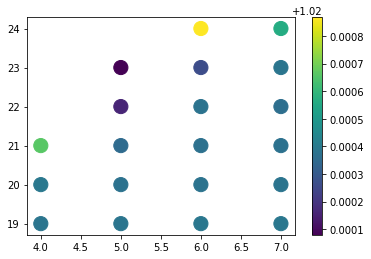

In [49]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
scat = ax.scatter([l[0] for l in jointList], [l[1] for l in jointList], c=[l[2] for l in jointList], s=200, marker='o')
fig.colorbar(scat)
plt.show()

### Joint distribution of Runtime between beta0 and N0 (in seconds)

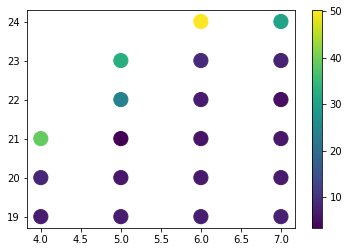

In [40]:
fig, ax = plt.subplots()
scat = ax.scatter([l[0] for l in jointList], [l[1] for l in jointList], c=[-l[3] for l in jointList], s=200, marker='o')
fig.colorbar(scat)
plt.show()

* Note: some of the points were left blank because it is too long to finish computing them

## Extra experiment: Forward Selection

In [57]:
import pandas
tFreq = countAllFrequencyNaive(data)
trainMyFeatures60FS = parseTransformedFeatures(train, lambda u, v: wordCountNaive(u, v, tFreq), 160, ['children', 'childrenT', 'controv', 'isRoot', 'text', 'textT']) # , 'child and controv', 'text'
validationMyFeatures60FS = parseTransformedFeatures(validation, lambda u, v: wordCountNaive(u, v, tFreq), 160, ['children', 'childrenT', 'controv', 'isRoot', 'text', 'textT'])
testMyFeatures60FS = parseTransformedFeatures(test, lambda u, v: wordCountNaive(u, v, tFreq), 160, ['children', 'childrenT', 'controv', 'isRoot', 'text', 'textT'])

[=================== ] 99%

In [58]:
traindf = pandas.DataFrame(trainMyFeatures60FS[0])
validationdf = pandas.DataFrame(validationMyFeatures60FS[0])
traindf.shape, validationdf.shape

((10000, 325), (1000, 325))

In [59]:
fullPredictors = set([i for i in range(0, 325)])
levelBest = [[sys.float_info.max, set()]]
c = 0
for k in range(1, len(fullPredictors)): 
    
    prevBest = min([l for l in levelBest if len(l[1]) == k - 1], key = lambda x: x[0])[1]
    currentPredictors = fullPredictors - prevBest
    mseVal = []
    
    for predictor in currentPredictors: 
        selected = prevBest | set([predictor])
        
        trainX = traindf[list(selected)].values
        validX = validationdf[list(selected)].values
        trainY = trainMyFeatures60[1]
        validY = validationMyFeatures60[1]
        
        try: 
            resultW = closedFormLinearRegression(trainX, trainY)
        except: 
            continue
        mseVal.append([meanSquareError(validX, validY, resultW), selected])
    
    currentBest = min(mseVal, key = lambda x: x[0])
    
    
    
    # Process Bar
    sys.stdout.write('\r')
    count = int((float(c) / float(len(fullPredictors))) * 100)
    sys.stdout.write("[%-20s] %d%%" % ('='*int(count / 5), count))
    if len(mseVal) > 0: 
        levelBest.append(currentBest)
        sys.stdout.write(str(currentBest))
    sleep(0.001)
    sys.stdout.flush()
    c = c + 1
    

trainX = traindf[list(fullPredictors)].values
validX = validationdf[list(fullPredictors)].values
trainY = trainMyFeatures60[1]
validY = validationMyFeatures60[1]
ok = True
try: 
    resultW = closedFormLinearRegression(trainX, trainY)
except: 
    ok = False
if ok: 
    mseVal.append([meanSquareError(validX, validY, resultW), selected])
bestOfAll = sorted(levelBest, key = lambda v: v[0])[0]

[=================== ] 99%[1.356295371298441, {0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 2

In [62]:
print('best set of predictors with interaction term: \n', bestOfAll[1])
print('error: \n', bestOfAll[0])
print('0-4: childrenTransformed, controv, isRoot, identity')
print('6-165: transformed text')
print('166-325: transformed text')

best set of predictors with interaction term: 
 {256, 1, 2, 3, 260, 258, 261, 263, 8, 9, 10, 266, 12, 269, 14, 257, 270, 17, 268, 18, 276, 277, 278, 279, 280, 22, 23, 259, 285, 287, 32, 289, 290, 291, 292, 293, 294, 295, 37, 298, 299, 302, 303, 46, 305, 306, 307, 308, 309, 53, 313, 318, 319, 320, 322, 324, 87, 166, 167, 171, 175, 179, 184, 185, 186, 187, 189, 191, 193, 194, 195, 196, 199, 201, 202, 203, 204, 205, 207, 209, 210, 212, 217, 219, 220, 221, 223, 224, 227, 228, 230, 231, 233, 234, 235, 236, 238, 241, 242, 244, 245, 250, 251, 253}
error: 
 0.9203750747469738
0-4: childrenTransformed, controv, isRoot, identity
6-165: transformed text
166-325: transformed text


## Final Performance

In [63]:
resultClosedFinal = closedFormLinearRegression(numpy.array(trainMyFeatures60FS[0])[:,list(bestOfAll[1])], trainMyFeatures60FS[1])
meanSquareError(numpy.array(testMyFeatures60FS[0])[:,list(bestOfAll[1])], testMyFeatures60FS[1], resultClosedFinal)

1.279439473930473

Conclusion: overfits validation set (meta-overfitting)